In [18]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torch import nn, optim
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataset import random_split
import datetime
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Import and transform dataset

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
    


In [20]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [21]:
# import os
# import shutil

# # Replace these paths with your actual dataset paths
# train_data_path = "dataset/train_oversampled"
# oversampled_train_data_path = "dataset/train_final"

# # Make a copy of the original training dataset to oversample
# shutil.copytree(train_data_path, oversampled_train_data_path)

# # Define the minority classes (you can modify this based on your dataset)
# minority_classes = ['Gulo', 'sama', 'agam']

# # Define the desired number of samples per class after oversampling
# desired_samples_per_class = 500

# # Oversample each minority class
# for class_name in minority_classes:
#     class_path = os.path.join(oversampled_train_data_path, class_name)
#     current_samples = len(os.listdir(class_path))
#     num_duplicates = desired_samples_per_class - current_samples
    
#     if num_duplicates <= 0:
#         continue
    
#     # Duplicate images in the minority class
#     image_files = os.listdir(class_path)
#     for i in range(num_duplicates):
#         image_file = image_files[i % current_samples]
#         source_path = os.path.join(class_path, image_file)
#         target_path = os.path.join(class_path, f"{class_name}_duplicate_{i}.jpg")
#         shutil.copy(source_path, target_path)

# # Now, the oversampled_train_data_path contains the oversampled training dataset
# # You can use this dataset for training your model with balanced class distributions.


In [22]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

train_data_path = "dataset/train_final"
test_data_path = "dataset/test"


train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transforms.ToTensor())


total_trainset_length = len(train_dataset)
val_size = int(0.2 * total_trainset_length)
train_size = total_trainset_length - val_size
test_size = len(test_dataset)


train_set, val_set, = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


len_trainset = len(train_set)
len_valset = len(val_set)
len_testset = len(test_dataset)


class_names = train_dataset.classes

train_class_names = train_dataset.classes
val_class_names = val_set.dataset.classes
test_class_names = test_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Train class names:", train_class_names)
print("Validation class names:", val_class_names)
print("Test class names:", test_class_names)

print("Train set length:", len_trainset)
print("Validation set length:", len_valset)
print("Test set length:", len_testset)
print("Class names:", class_names)


Train class names: ['Gulo', 'QEtetit', 'agam', 'birbira', 'embis', 'endawela', 'sama', 'shinet']
Validation class names: ['Gulo', 'QEtetit', 'agam', 'birbira', 'embis', 'endawela', 'sama', 'shinet']
Test class names: ['Gulo', 'QEtetit', 'agam', 'birbira', 'embis', 'endawela', 'sama', 'shinet']
Train set length: 3221
Validation set length: 805
Test set length: 293
Class names: ['Gulo', 'QEtetit', 'agam', 'birbira', 'embis', 'endawela', 'sama', 'shinet']


Number of images per class in the training set:
Class 'Gulo': 500 images
Class 'QEtetit': 500 images
Class 'agam': 500 images
Class 'birbira': 500 images
Class 'embis': 526 images
Class 'endawela': 500 images
Class 'sama': 500 images
Class 'shinet': 500 images
Number of images per class in the validation set:
Class 'birbira': 111 images
Class 'endawela': 104 images
Class 'sama': 83 images
Class 'shinet': 95 images
Class 'agam': 100 images
Class 'QEtetit': 94 images
Class 'Gulo': 108 images
Class 'embis': 110 images
Number of images per class in the test set:
Class 'Gulo': 43 images
Class 'QEtetit': 26 images
Class 'agam': 40 images
Class 'birbira': 35 images
Class 'embis': 65 images
Class 'endawela': 28 images
Class 'sama': 27 images
Class 'shinet': 29 images


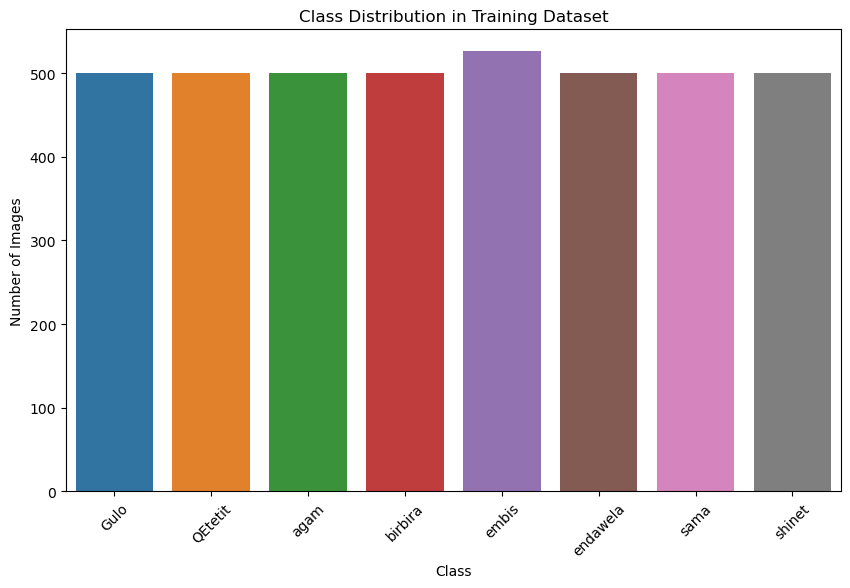

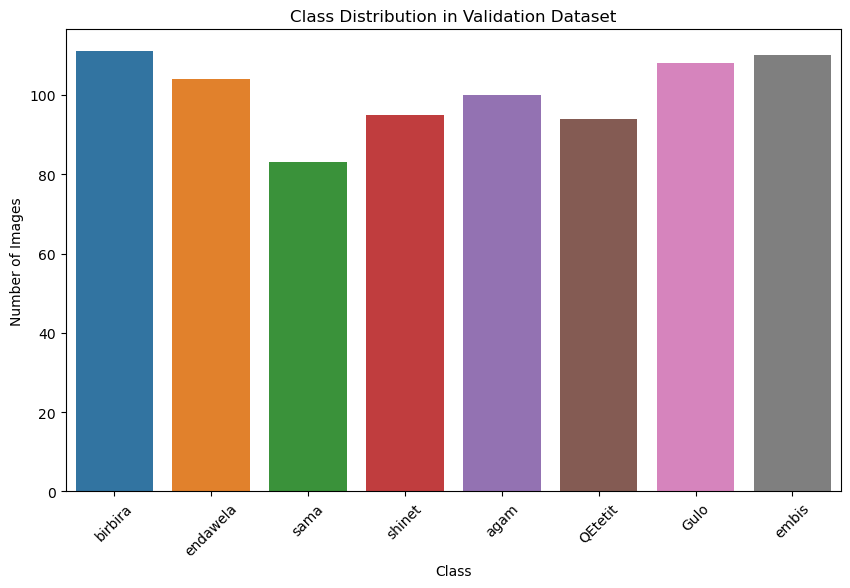

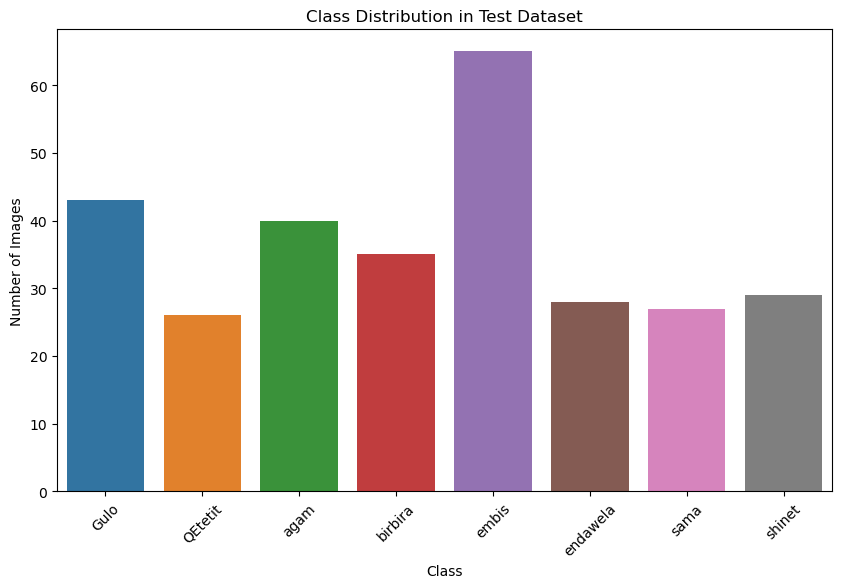

In [23]:

def count_images_per_class(dataset):
    class_counts = {}
    for _, label in dataset:
        class_name = train_dataset.classes[label]
        if class_name not in class_counts:
            class_counts[class_name] = 1
        else:
            class_counts[class_name] += 1
    return class_counts


train_class_counts = count_images_per_class(train_dataset)
print("Number of images per class in the training set:")
for class_name, count in train_class_counts.items():
    print(f"Class '{class_name}': {count} images")


val_class_counts = count_images_per_class(val_set)
print("Number of images per class in the validation set:")
for class_name, count in val_class_counts.items():
    print(f"Class '{class_name}': {count} images")


test_class_counts = count_images_per_class(test_dataset)
print("Number of images per class in the test set:")
for class_name, count in test_class_counts.items():
    print(f"Class '{class_name}': {count} images")

def plot_class_distribution(class_counts, dataset_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(f"Class Distribution in {dataset_name} Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_class_counts, "Training")
plot_class_distribution(val_class_counts, "Validation")
plot_class_distribution(test_class_counts, "Test")

In [24]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels)
print(len(train_loader))

torch.Size([32, 3, 224, 224])
tensor([1, 4, 6, 7, 4, 3, 0, 0, 6, 3, 4, 4, 6, 0, 0, 0, 3, 0, 2, 4, 6, 4, 6, 0,
        0, 5, 0, 0, 6, 3, 5, 3])
101


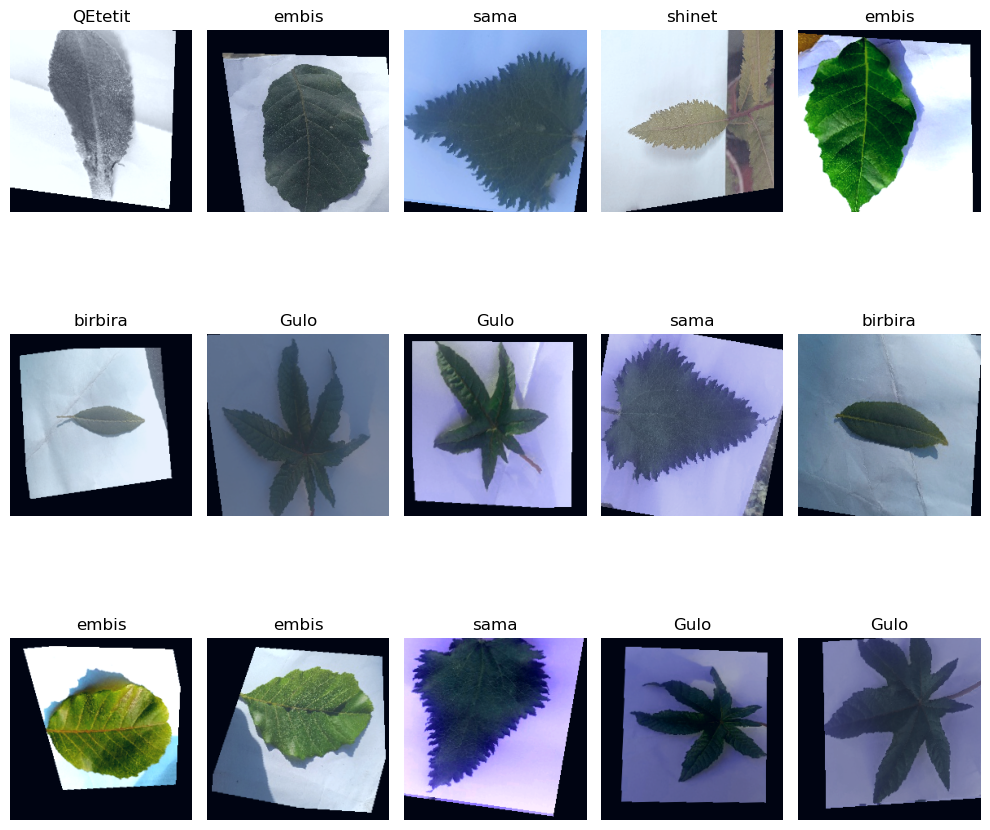

In [25]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)

    image = images[i] 
    image = F.normalize(image, mean=[-0.485 / 0.229], std=[1 / 0.229])  
    image = image.numpy().transpose(1, 2, 0) 

    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [26]:
# plt.figure(figsize=(10,10))
# for i in range(15):
#     ax = plt.subplot(3, 5, i+1)
#     plt.imshow(images[i].numpy().transpose(1,2,0))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Teacher network using resnet

In [27]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.layer4.parameters():
    param.requires_grad = True

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 8)
resnet = resnet.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001, weight_decay=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train teacher network

In [28]:
from sklearn.metrics import confusion_matrix

def train_and_evaluate(model, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs=25):
    model.to(device)
    model.train()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    all_val_preds = []
    all_val_labels = []
    history = {'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [], 'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

    # Add learning rate scheduler (StepLR example)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() 
            optimizer.step()  
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_preds += preds.cpu().numpy().tolist()
            running_labels += labels.data.cpu().numpy().tolist()

        epoch_loss = running_loss / len_trainset
        epoch_acc = running_corrects.double() / len_trainset
        epoch_precision = precision_score(running_labels, running_preds, average='weighted', zero_division=1)
        epoch_recall = recall_score(running_labels, running_preds, average='weighted', zero_division=1)
        epoch_f1 = f1_score(running_labels, running_preds, average='weighted', zero_division=1)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['train_precision'].append(epoch_precision)
        history['train_recall'].append(epoch_recall)
        history['train_f1'].append(epoch_f1)
        print(' Train Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1 Score: {:.4f}'.format(epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1)) 
         
        model.eval()
        running_loss_val = 0.0 
        running_corrects_val = 0
        running_preds_val = []
        running_labels_val = []

        for inputs, labels in valloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
            running_preds_val += preds.cpu().numpy().tolist()
            running_labels_val += labels.data.cpu().numpy().tolist()
      
        epoch_loss_val = running_loss_val / len_valset
        epoch_acc_val = running_corrects_val.double() / len_valset
        epoch_precision_val = precision_score(running_labels_val, running_preds_val, average='weighted', zero_division=1)
        epoch_recall_val = recall_score(running_labels_val, running_preds_val, average='weighted', zero_division=1)
        epoch_f1_val = f1_score(running_labels_val, running_preds_val, average='weighted', zero_division=1)
        
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
      
        history['val_loss'].append(epoch_loss_val)
        history['val_acc'].append(epoch_acc_val)
        print(' Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        all_val_preds += running_preds_val
        all_val_labels += running_labels_val
    
        scheduler.step()
    
    cm = confusion_matrix(all_val_labels, all_val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Validation Set)')
    plt.show()
    
    print()
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model, history


Epoch 0/99
----------
 Train Loss: 0.2154 Acc: 0.9404 Precision: 0.9406 Recall: 0.9404 F1 Score: 0.9404
 Val Loss: 0.1156 Acc: 0.9602
Epoch 1/99
----------
 Train Loss: 0.1358 Acc: 0.9696 Precision: 0.9696 Recall: 0.9696 F1 Score: 0.9696
 Val Loss: 0.1163 Acc: 0.9789
Epoch 2/99
----------
 Train Loss: 0.0835 Acc: 0.9801 Precision: 0.9802 Recall: 0.9801 F1 Score: 0.9801
 Val Loss: 0.3059 Acc: 0.8957
Epoch 3/99
----------
 Train Loss: 0.0964 Acc: 0.9761 Precision: 0.9762 Recall: 0.9761 F1 Score: 0.9761
 Val Loss: 0.3653 Acc: 0.9006
Epoch 4/99
----------
 Train Loss: 0.0763 Acc: 0.9854 Precision: 0.9854 Recall: 0.9854 F1 Score: 0.9854
 Val Loss: 0.3677 Acc: 0.9317
Epoch 5/99
----------
 Train Loss: 0.0399 Acc: 0.9904 Precision: 0.9904 Recall: 0.9904 F1 Score: 0.9904
 Val Loss: 0.0064 Acc: 0.9988
Epoch 6/99
----------
 Train Loss: 0.0264 Acc: 0.9963 Precision: 0.9963 Recall: 0.9963 F1 Score: 0.9963
 Val Loss: 0.0164 Acc: 0.9950
Epoch 7/99
----------
 Train Loss: 0.0279 Acc: 0.9960 Precisio

 Val Loss: 0.0035 Acc: 1.0000
Epoch 61/99
----------
 Train Loss: 0.0184 Acc: 0.9988 Precision: 0.9988 Recall: 0.9988 F1 Score: 0.9988
 Val Loss: 0.0039 Acc: 1.0000
Epoch 62/99
----------
 Train Loss: 0.0181 Acc: 0.9981 Precision: 0.9981 Recall: 0.9981 F1 Score: 0.9981
 Val Loss: 0.0031 Acc: 1.0000
Epoch 63/99
----------
 Train Loss: 0.0192 Acc: 0.9984 Precision: 0.9984 Recall: 0.9984 F1 Score: 0.9984
 Val Loss: 0.0027 Acc: 1.0000
Epoch 64/99
----------
 Train Loss: 0.0147 Acc: 0.9991 Precision: 0.9991 Recall: 0.9991 F1 Score: 0.9991
 Val Loss: 0.0030 Acc: 1.0000
Epoch 65/99
----------
 Train Loss: 0.0163 Acc: 0.9984 Precision: 0.9985 Recall: 0.9984 F1 Score: 0.9984
 Val Loss: 0.0037 Acc: 1.0000
Epoch 66/99
----------
 Train Loss: 0.0152 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1 Score: 0.9997
 Val Loss: 0.0031 Acc: 1.0000
Epoch 67/99
----------
 Train Loss: 0.0142 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1 Score: 0.9997
 Val Loss: 0.0031 Acc: 1.0000
Epoch 68/99
----------
 T

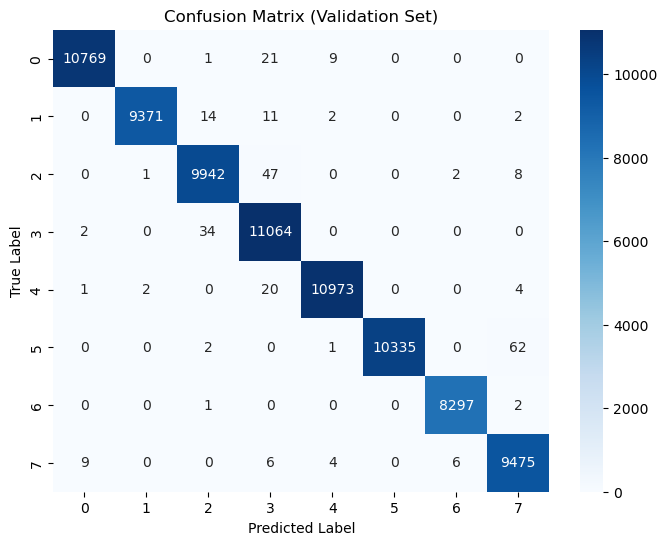


Best val Acc: 1.000000


In [29]:
resnet_teacher, history = train_and_evaluate(resnet, train_loader, val_loader, criterion, optimizer, len_trainset, len_valset, 100)
torch.save(resnet_teacher.state_dict(), 'models/resnet_teacher.pth')

In [30]:

model_path = f"models/resnet_teacher_{timestamp}.pth"
torch.save(resnet_teacher.state_dict(), model_path)

#### Loading my pretrained teacher model

In [46]:
resnet_teacher = models.resnet50(pretrained=False) 
resnet_teacher.fc = nn.Linear(resnet_teacher.fc.in_features, 8)

model_path = 'models/resnet_teacher_20230719_162358.pth'
model_state_dict = torch.load(model_path)
resnet_teacher.load_state_dict(model_state_dict)
resnet_teacher.eval()

/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Plot training, validation accuracy and loss - Teacher model

In [31]:
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(history['train_loss'], label='Training Loss')
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss Curves')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history['train_acc'], label='Training Accuracy')
    axs[1].plot(history['val_acc'], label='Validation Accuracy')
    axs[1].set_title('Accuracy Curves')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()
    plt.savefig(f'teacher_training_history_{timestamp}.png')

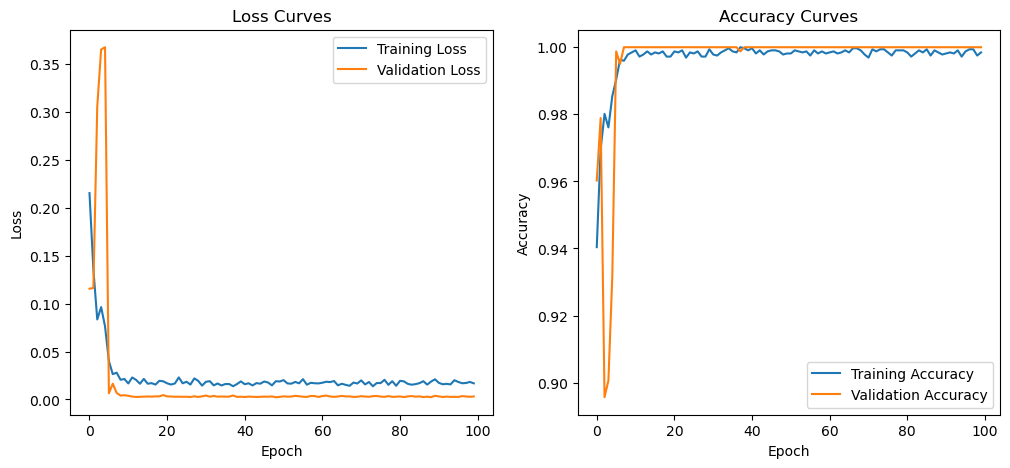

<Figure size 640x480 with 0 Axes>

In [32]:
plot_training_history(history)

#### Testing the teacher model

In [33]:
def test_model(model, testloader, len_testset):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print('Accuracy of the network on the test images: {:.2f}%'.format(100 * accuracy))
    
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    confidence = torch.nn.functional.softmax(outputs, dim=1)
    
    image = images[0].cpu().numpy().transpose((1, 2, 0))

    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    
    print('Actual label: ', class_names[labels[0]])
    print('Predicted label: ', class_names[predicted[0]])
    print('Confidence: {:.2f}%'.format(100 * confidence[0, predicted[0]]))


Accuracy of the network on the test images: 100.00%
Actual label:  sama
Predicted label:  sama
Confidence: 97.07%


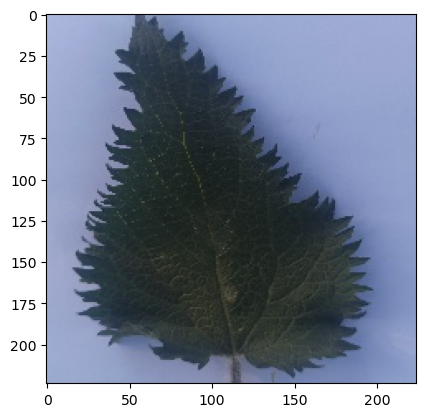

In [35]:
test_model(resnet_teacher, test_loader, len_testset)

In [36]:
def test_model_batch(model, testloader, len_testset, num_images=12):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print('Accuracy of the network on the test images: {:.2f}%'.format(100 * accuracy))
    
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images = images[:num_images].to(device)
    labels = labels[:num_images].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    confidence = torch.nn.functional.softmax(outputs, dim=1)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(3, 4, i + 1)
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(image)
        plt.title('Actual: {}, Predicted: {}\nConfidence: {:.2f}%'.format(
            class_names[labels[i]], class_names[predicted[i]], 100 * confidence[i, predicted[i]]))
        plt.axis('off')


Accuracy of the network on the test images: 100.00%


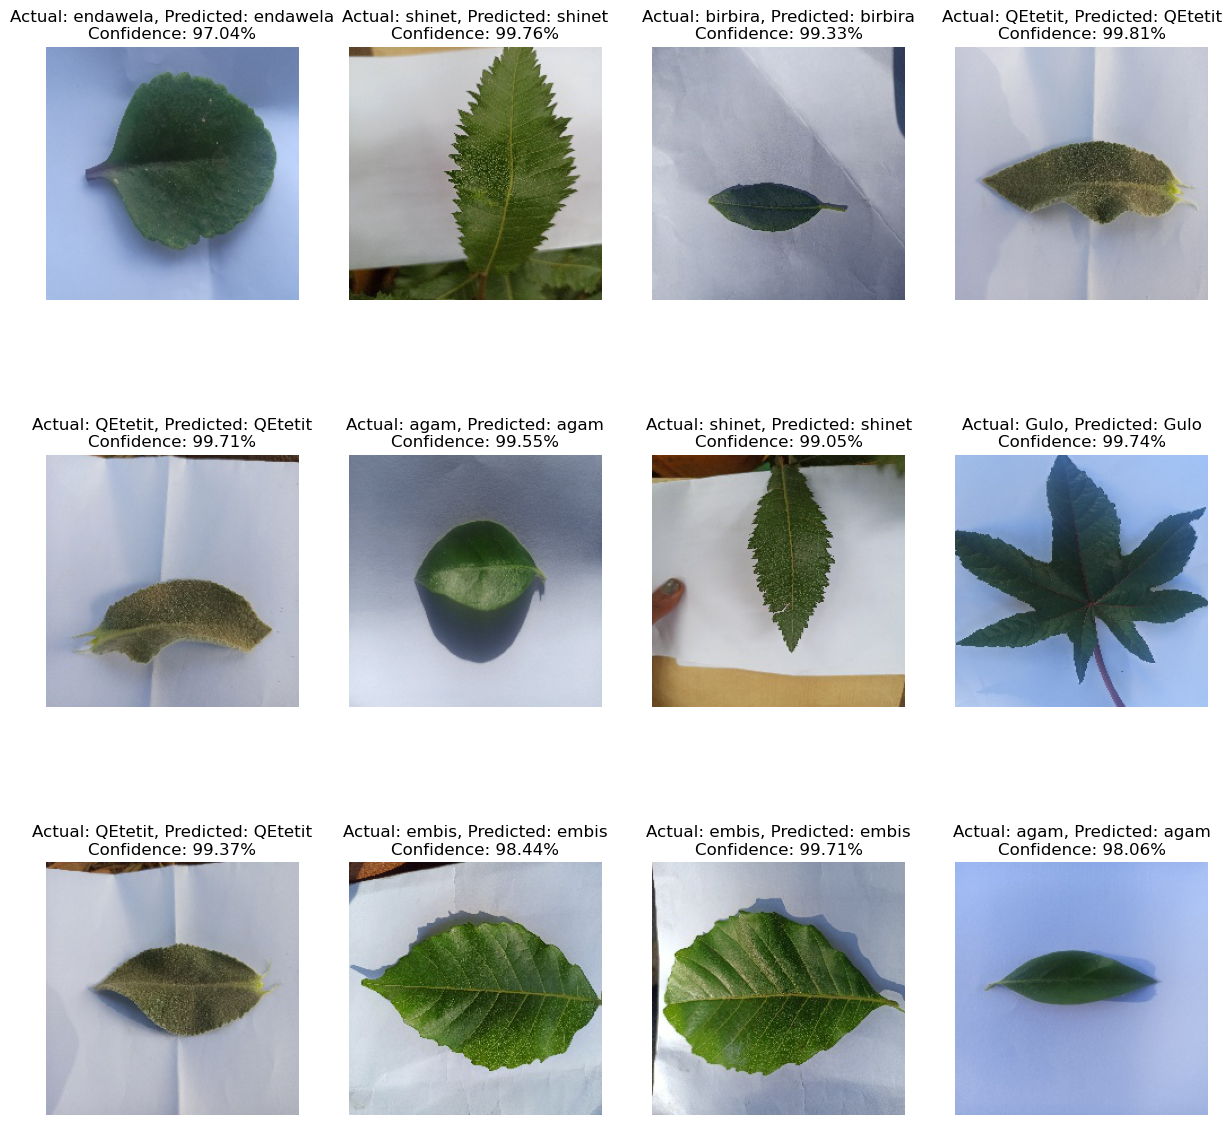

In [37]:
test_model_batch(resnet_teacher, test_loader, len_testset, num_images=12)

### Testing for unknown data

In [42]:
import torch
import torchvision.transforms as transforms
from PIL import Image

unknown_image_path = "dataset/unknown/agam/cat2.jpeg"
unknown_image = Image.open(unknown_image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
  
unknown_image_tensor = transform(unknown_image).unsqueeze(0) 
unknown_image_tensor = unknown_image_tensor.to(device)

resnet_teacher.eval()

with torch.no_grad():
    outputs = resnet_teacher(unknown_image_tensor)
    _, predicted = torch.max(outputs, 1)
    confidence = torch.nn.functional.softmax(outputs, dim=1)

predicted_label = class_names[predicted.item()]
confidence_percent = 100 * confidence[0, predicted].item()

print('Predicted label: ', predicted_label)
print('Confidence: {:.2f}%'.format(confidence_percent))


Predicted label:  birbira
Confidence: 42.41%


In [43]:

checkpoint_path = f"models/resnet_teacher_checkpoint_{timestamp}.pth"

checkpoint = {
    'model_state_dict': resnet_teacher.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}
torch.save(checkpoint, checkpoint_path)


In [ ]:

checkpoint = torch.load('models/resnet_teacher_checkpoint_20230605_041304.pth')
resnet_teacher.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']


### Student network
##### Student network will learn from the teacher network

In [88]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class Net(nn.Module):
    def __init__(self, pretrained=True):
        super(Net, self).__init__()
        self.base_model = models.resnet50(pretrained=pretrained)
        self.fc1 = nn.Linear(1000, 32)
        self.fc2 = nn.Linear(32, 8)
        self.dropout_rate = 0.5

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

net = Net(pretrained=True).to(device)

std_optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001, weight_decay=0.01)
std_scheduler = optim.lr_scheduler.StepLR(std_optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()


In [89]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
out = net(images)
print(out.shape)
print("Train set length:", len_trainset)
print("Validation set length:", len_valset)
print("Test set length:", len_testset)


torch.Size([32, 8])
Train set length: 3221
Validation set length: 805
Test set length: 293


#### Loss function

In [90]:
def loss_kd(outputs, labels, teacher_outputs, temperature, alpha):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/temperature, dim=1),
                             F.softmax(teacher_outputs/temperature, dim=1)) * (alpha * temperature * temperature) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss


def get_outputs(model, dataloader):
    outputs = []
    for inputs, labels in dataloader:
        inputs_batch, labels_batch = inputs.cpu(), labels.cpu()
        output_batch = model(inputs_batch).data.cpu().numpy()
        outputs.append(output_batch)
    return outputs

### Knowledge distillation
#### Student network learning from teacher network

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train_kd(model, teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    true_labels = []
    pred_labels = []
    
    for i, (images, labels) in enumerate(dataloader):
        inputs = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs_teacher = torch.from_numpy(teacher_out[i]).to(device)
        loss = loss_kd(outputs, labels, outputs_teacher, temparature, alpha)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    epoch_precision = precision_score(true_labels, pred_labels, average='macro', zero_division=1)
    epoch_recall = recall_score(true_labels, pred_labels, average='macro', zero_division=1)
    epoch_f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=1)
    
    print('Train Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1))
    
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1


def eval_kd(model, teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    true_labels = []
    pred_labels = []
    
    for i, (images, labels) in enumerate(dataloader):
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs_teacher = torch.from_numpy(teacher_out[i]).cpu()
        loss = loss_kd(outputs, labels, outputs_teacher, temparature, alpha)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    epoch_precision = precision_score(true_labels, pred_labels, average='macro', zero_division=1)
    epoch_recall = recall_score(true_labels, pred_labels, average='macro', zero_division=1)
    epoch_f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=1)
    
    print('Val Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1))
    
    return epoch_acc, epoch_loss, epoch_precision, epoch_recall, epoch_f1

def train_and_evaluate_kd(model, teacher_model, optimizer, scheduler, loss_kd, trainloader, valloader, temparature, alpha, num_epochs=25):
    teacher_model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    outputs_teacher_train = get_outputs(teacher_model, trainloader)
    outputs_teacher_val = get_outputs(teacher_model, valloader)
    print("Teacher's outputs are computed, now starting the training process...")
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
               'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss, train_acc, train_precision, train_recall, train_f1 = train_kd(model, outputs_teacher_train, optimizer, loss_kd, trainloader, temparature, alpha)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)

        val_acc, val_loss, val_precision, val_recall, val_f1 = eval_kd(model, outputs_teacher_val, optimizer, loss_kd, valloader, temparature, alpha)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print('Best val Acc: {:4f}'.format(best_acc))
            model.load_state_dict(best_model_wts)

        scheduler.step()

    return model, history


In [92]:
student_model, history = train_and_evaluate_kd(net,resnet_teacher, std_optimizer, std_scheduler, loss_kd,train_loader,val_loader,1,0.1,100)
torch.save(student_model.state_dict(), f"models/student_model_{timestamp}.pth")

Teacher's outputs are computed, now starting the training process...
Epoch 0/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.2089 Acc: 0.9621 Precision: 0.9627 Recall: 0.9620 F1: 0.9622


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0952 Acc: 0.9988 Precision: 0.9987 Recall: 0.9987 F1: 0.9987
Best val Acc: 0.998758
Epoch 1/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1164 Acc: 0.9929 Precision: 0.9929 Recall: 0.9929 F1: 0.9929


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0981 Acc: 0.9988 Precision: 0.9988 Recall: 0.9989 F1: 0.9988
Epoch 2/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1108 Acc: 0.9947 Precision: 0.9947 Recall: 0.9947 F1: 0.9947


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.1158 Acc: 0.9913 Precision: 0.9915 Recall: 0.9898 F1: 0.9904
Epoch 3/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1454 Acc: 0.9832 Precision: 0.9833 Recall: 0.9833 F1: 0.9833


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.1468 Acc: 0.9839 Precision: 0.9844 Recall: 0.9834 F1: 0.9836
Epoch 4/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1122 Acc: 0.9932 Precision: 0.9932 Recall: 0.9932 F1: 0.9932


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.1313 Acc: 0.9901 Precision: 0.9907 Recall: 0.9908 F1: 0.9905
Epoch 5/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1301 Acc: 0.9898 Precision: 0.9898 Recall: 0.9896 F1: 0.9897


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.2233 Acc: 0.9752 Precision: 0.9766 Recall: 0.9770 F1: 0.9757
Epoch 6/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1559 Acc: 0.9832 Precision: 0.9834 Recall: 0.9833 F1: 0.9834


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0919 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Best val Acc: 1.000000
Epoch 7/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1116 Acc: 0.9957 Precision: 0.9957 Recall: 0.9957 F1: 0.9957


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0915 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 8/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1416 Acc: 0.9848 Precision: 0.9848 Recall: 0.9848 F1: 0.9848


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.3736 Acc: 0.8919 Precision: 0.9398 Recall: 0.8958 F1: 0.9013
Epoch 9/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1364 Acc: 0.9873 Precision: 0.9873 Recall: 0.9873 F1: 0.9873


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.1060 Acc: 0.9963 Precision: 0.9961 Recall: 0.9962 F1: 0.9961
Epoch 10/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.1074 Acc: 0.9957 Precision: 0.9957 Recall: 0.9957 F1: 0.9957


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0894 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 11/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0952 Acc: 0.9984 Precision: 0.9984 Recall: 0.9984 F1: 0.9984


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0876 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 12/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0934 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0843 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 13/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0920 Acc: 0.9991 Precision: 0.9991 Recall: 0.9991 F1: 0.9991


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0872 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 14/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0914 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0827 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 15/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0915 Acc: 0.9991 Precision: 0.9991 Recall: 0.9991 F1: 0.9991


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0848 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 16/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0895 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0812 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 17/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0877 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0813 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 18/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0866 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0828 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 19/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0875 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0832 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 20/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0868 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0814 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 21/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0863 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0822 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 22/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0852 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0806 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 23/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0866 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 24/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0844 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0809 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 25/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0819 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 26/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0864 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0803 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 27/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0841 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0813 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 28/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0853 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0823 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 29/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0860 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0797 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 30/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0836 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0829 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 31/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0850 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0807 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 32/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0861 Acc: 0.9991 Precision: 0.9991 Recall: 0.9991 F1: 0.9991


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0815 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 33/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0842 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0812 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 34/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0851 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0822 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 35/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0857 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0817 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 36/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0855 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0814 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 37/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0851 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 38/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0864 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0804 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 39/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0841 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0806 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 40/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0793 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 41/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0846 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0810 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 42/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0852 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 43/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0843 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0811 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 44/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0826 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 45/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0868 Acc: 0.9991 Precision: 0.9991 Recall: 0.9991 F1: 0.9991


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0818 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 46/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0854 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0822 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 47/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0856 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0805 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 48/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0849 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0793 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 49/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0844 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0801 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 50/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0844 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0822 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 51/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0843 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0795 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 52/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0842 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 53/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0841 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0826 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 54/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0846 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0827 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 55/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0840 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0812 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 56/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0854 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0813 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 57/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0800 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 58/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0839 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0801 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 59/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0853 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 60/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0841 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0791 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 61/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0810 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 62/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0840 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0821 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 63/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0865 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0813 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 64/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0862 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0806 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 65/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0851 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0826 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 66/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0849 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0799 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 67/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0850 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0835 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 68/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0830 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 69/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0855 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 70/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0862 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0805 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 71/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0843 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0814 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 72/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0844 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0800 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 73/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0851 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0801 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 74/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0838 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0812 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 75/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0842 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0819 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 76/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0840 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 77/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0864 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0795 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 78/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0859 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0813 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 79/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0852 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0823 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 80/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0843 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0811 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 81/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0839 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0806 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 82/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0844 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0820 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 83/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0854 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0785 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 84/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0836 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0822 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 85/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0817 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 86/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0820 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 87/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0853 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 88/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0842 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0801 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 89/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0848 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0824 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 90/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0847 Acc: 0.9994 Precision: 0.9994 Recall: 0.9994 F1: 0.9994


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0817 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 91/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0859 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0816 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 92/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0853 Acc: 0.9997 Precision: 0.9997 Recall: 0.9997 F1: 0.9997


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0793 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 93/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0851 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0792 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 94/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0843 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0807 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 95/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0849 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0824 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 96/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0839 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0817 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 97/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0845 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0818 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 98/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0829 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0794 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Epoch 99/99
----------


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train Loss: 0.0848 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


/Users/samuelobeng/Documents/Masters Thesis/plant-classification/env/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Val Loss: 0.0823 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000


In [93]:

model_path = f"models/student_model.pth"
torch.save(student_model.state_dict(), model_path)

In [94]:

checkpoint_path = f"models/student_model_checkpoint_{timestamp}.pth"

checkpoint = {
    'student_model_state_dict': student_model.state_dict(),
    'optimizer_state_dict': optim.Adam(net.parameters(), lr=0.001).state_dict(),
    'student_history': history
}
torch.save(checkpoint, checkpoint_path)


### Graph of the student model training

In [95]:
import matplotlib.pyplot as plt

def plot_student_history(history):
    train_loss = history['train_loss']
    train_acc = history['train_acc']

    val_loss = history['val_loss']
    val_acc = history['val_acc']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()
    plt.savefig(f'student_training_history_{timestamp}.png')

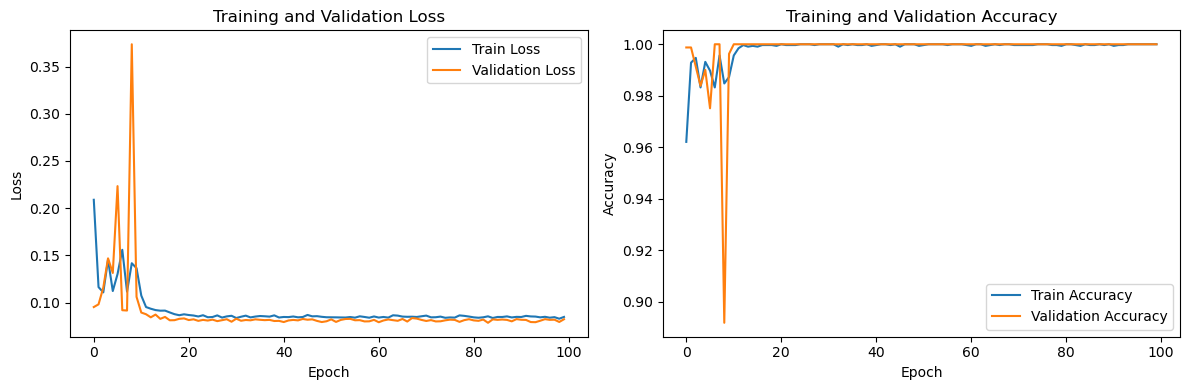

<Figure size 640x480 with 0 Axes>

In [96]:
plot_student_history(history)

## Testing the student model for prediction

In [97]:
def student_test_model_batch(model, testloader, len_testset, num_images=9):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print('Accuracy of the network on the test images: {:.2f}%'.format(100 * accuracy))
    
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    confidence = torch.nn.functional.softmax(outputs, dim=1)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(image)
        plt.title('Actual label: {}, Predicted label: {}\nConfidence: {:.2f}%'.format(
            class_names[labels[i]], class_names[predicted[i]], 100 * confidence[i, predicted[i]]
        ))
        plt.axis('off')
    
    plt.show()

Accuracy of the network on the test images: 98.98%


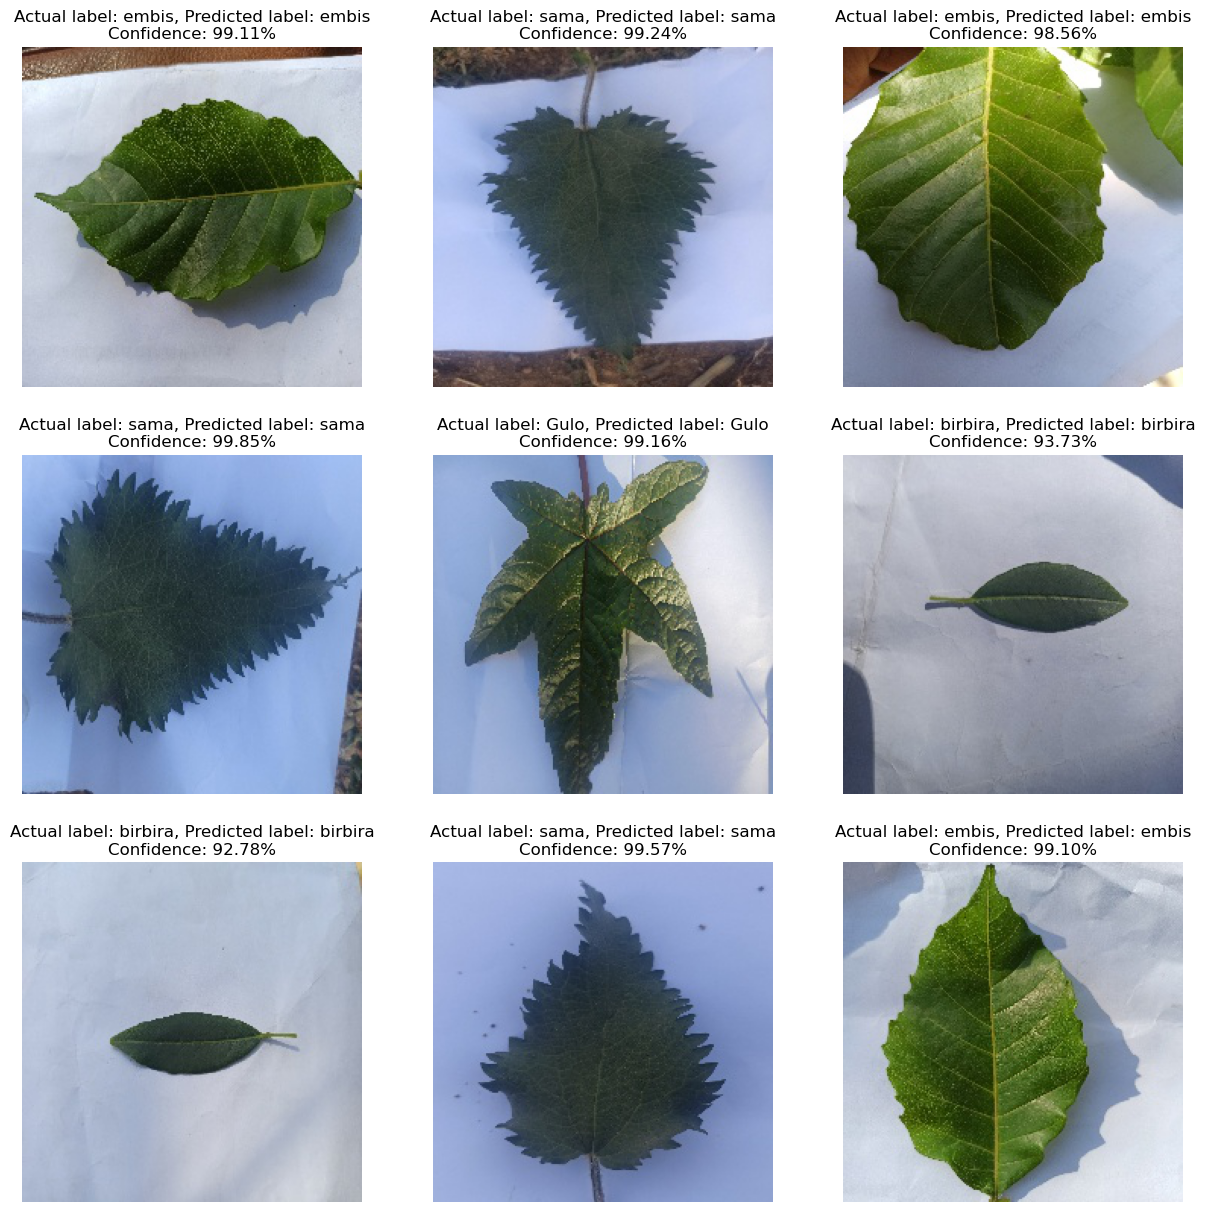

In [98]:
student_test_model_batch(student_model, test_loader, len_testset)

In [106]:
import torch
import torchvision.transforms as transforms
from PIL import Image

unknown_image_path = "dataset/unknown/agam/tomato2.jpeg"
unknown_image = Image.open(unknown_image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
  
unknown_image_tensor = transform(unknown_image).unsqueeze(0)  
unknown_image_tensor = unknown_image_tensor.to(device)

student_model.eval()

with torch.no_grad():
    outputs = student_model(unknown_image_tensor)
    _, predicted = torch.max(outputs, 1)
    confidence = torch.nn.functional.softmax(outputs, dim=1)

predicted_label = class_names[predicted.item()]
confidence_percent = 100 * confidence[0, predicted].item()

print('Predicted label: ', predicted_label)
print('Confidence: {:.2f}%'.format(confidence_percent))


Predicted label:  embis
Confidence: 96.22%


In [ ]:
# Load the saved model state dictionary
student_model = Net(num_classes=8)
model_path = 'models/student_model_20230717_093833.pth'
model_state_dict = torch.load(model_path)
student_model.load_state_dict(model_state_dict)
student_model.eval()

# Explainability with LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(0.9840058088302612, 0, 'Gulo'), (0.002973807044327259, 5, 'endawela'), (0.0025087036192417145, 4, 'embis'), (0.0023803357034921646, 7, 'shinet'), (0.0021246387623250484, 6, 'sama')]


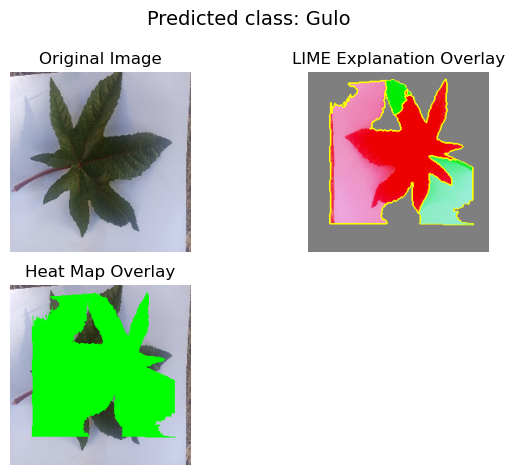

In [128]:
import lime
from lime import lime_image
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
from skimage.segmentation import mark_boundaries


# Load the test image
img = Image.open('dataset/test/Gulo/IMG_20210203_171624_1.jpg').convert('RGB')

# Assuming you have a trained student model named "student_model"
model = student_model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model.eval()
input_img = transform(img).unsqueeze(dim=0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


def predict_fn(images):
    images = torch.from_numpy(images.transpose((0, 3, 1, 2)))  # Adjust the dimensions
    model.eval()
    with torch.no_grad():
        logits = model(images)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    input_img.squeeze().numpy().transpose((1, 2, 0)),
    predict_fn,
    top_labels=5,
    num_features=8
)


# Get the class names
class_names = class_names

# Print the top predictions
with torch.no_grad():
    logits = model(input_img)
    probs = torch.nn.functional.softmax(logits, dim=1)
    _, top_classes = torch.topk(probs, k=5, dim=1)
    predictions = [(probs[0][c].item(), c.item(), class_names[c.item()]) for c in top_classes[0]]
print(predictions)

# Show the explanation
explanation_image, explanation_mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=8, hide_rest=True
)

# Get the explanation text
explanation_text = ''
for label, weight in explanation.local_exp[explanation.top_labels[0]]:
    explanation_text += f"Label: {label} - Weight: {weight}\n"

# Display the original image 
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

# Display the original image with the LIME explanation overlay
plt.subplot(2, 2, 2)
plt.imshow(mark_boundaries(explanation_image / 2 + 0.5, explanation_mask))
plt.axis('off')
plt.title('LIME Explanation Overlay')

# Generate the heat map overlay
heatmap_overlay = np.zeros_like(explanation_image)
heatmap_overlay[explanation_mask != 0] = explanation_image[explanation_mask != 0]

# Create the heat map overlay on the original image
heatmap = img.convert('RGB')
heatmap = np.array(heatmap)
heatmap[explanation_mask != 0] = np.array([0, 255, 0])  # Set the heat map color (red) for the masked region

# Display the heat map overlay on the original image
plt.subplot(2, 2, 3)
plt.imshow(heatmap)
plt.axis('off')
plt.title('Heat Map Overlay')

# Adjust the spacing between subplots
plt.tight_layout()

# Get the predicted class
predicted_class_name = predictions[0][2]

# Display the predicted class
plt.suptitle(f"Predicted class: {predicted_class_name}", fontsize=14)

# Add a space
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()


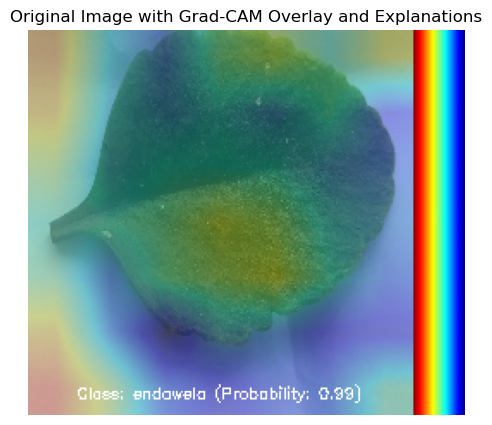

In [122]:
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the Grad-CAM function
def grad_cam(model, input_img, target_layer):
    # Set the model to evaluation mode
    model.eval()

    # Register a forward hook to get the feature maps
    feature_maps = None

    def get_feature_maps(module, input, output):
        nonlocal feature_maps
        feature_maps = output.detach()

    hook_handle = model.base_model.layer4.register_forward_hook(get_feature_maps)

    # Forward pass
    model(input_img)

    # Remove the hook
    hook_handle.remove()

    # Get the feature maps
    feature_maps = feature_maps.squeeze(0)

    # Calculate the gradients of the target layer with respect to the feature maps
    target = feature_maps[target_layer].unsqueeze(0)
    target.requires_grad_()
    output = torch.sum(target)
    model.zero_grad()
    output.backward(retain_graph=True)
    grads = target.grad.detach()

    # Compute the weights using global average pooling
    weights = torch.mean(grads, dim=(1, 2), keepdim=True)

    # Perform weighted combination of feature maps
    cam = torch.sum(weights * feature_maps, dim=0)

    # Normalize the cam values between 0 and 1
    cam = torch.clamp(cam, min=0)
    cam = cam / torch.max(cam)

    return cam.cpu().numpy()


# Load the test image
img = Image.open('dataset/test/endawela/IMG_20210203_173431.jpg').convert('RGB')

# Assuming you have a trained student model named "net"
model = student_model

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_img = transform(img).unsqueeze(0)

# Choose the target layer for Grad-CAM
target_layer = 7

# Perform Grad-CAM
cam = grad_cam(model, input_img, target_layer)

# Resize the cam to match the input image size
cam = cv2.resize(cam, (img.size[0], img.size[1]))

# Normalize the cam values between 0 and 255
cam = (255 * cam).astype(np.uint8)


# Apply the cam as an overlay on the original image
cam_overlay = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
gradcam_image = cv2.addWeighted(np.array(img), 0.7, cam_overlay, 0.3, 0)

# Assuming you have a list of class names used in your model
class_names = ['Gulo', 'QEtetit', 'agam', 'birbira', 'embis', 'endawela', 'sama', 'shinet']

# Get the model's prediction for the input image
with torch.no_grad():
    model.eval()
    output = model(input_img)

# Get the predicted class index and probability
pred_class_index = torch.argmax(output).item()
pred_probability = torch.softmax(output, dim=1)[0, pred_class_index].item()

# Add class activation information to the Grad-CAM image
class_activation_text = f'Class: {class_names[pred_class_index]} (Probability: {pred_probability:.2f})'
text_color = (255, 255, 255)  # White text color
text_font_scale = 0.3
text_thickness = 1
text_size, _ = cv2.getTextSize(class_activation_text, cv2.FONT_HERSHEY_SIMPLEX, text_font_scale, text_thickness)
text_x = (img.size[0] - text_size[0]) // 2
text_y = img.size[1] - 10
cv2.putText(gradcam_image, class_activation_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, text_font_scale, text_color, text_thickness)

# Add color bar for Grad-CAM values
color_bar = cv2.applyColorMap(np.arange(256, dtype=np.uint8).reshape(1, -1), cv2.COLORMAP_JET)
gradcam_colorbar = cv2.resize(color_bar, (30, img.size[1]))
gradcam_image = np.hstack((gradcam_image, gradcam_colorbar))

# Display the original image with Grad-CAM overlay and explanations
plt.figure(figsize=(10, 5))
plt.imshow(gradcam_image)
plt.axis('off')
plt.title('Original Image with Grad-CAM Overlay and Explanations')

# Show the plot
plt.show()